Importamos los paquetes necesarios y definimos el modelo

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import scipy.stats as st
from scipy.optimize import minimize
import math
from multiprocessing import Pool
import emcee
import seaborn as sns
import pandas as pd # Import pandas to handle the data set
import itertools

def Omega_k(Omega_m0, Omega_l0, Omega_r0):
    Omega_k0 = 1 - Omega_m0 - Omega_l0 - Omega_r0
    return Omega_k0

def E(x, Omega_m0):
    Omega_r0 = 0
    Omega_l0 = 1 - Omega_m0    
    return np.sqrt(Omega_m0*(1+x)**3 + Omega_l0)

def IntFunct(x, Omega_m0):
    return E(x, Omega_m0)**(-1)

def integral(z, Omega_m0):
    return integrate.quad(IntFunct,0, z, args=(Omega_m0),epsabs=1.49e-4, epsrel=1.49e-03,full_output = 1)[0]

def distancia_luminosidad(z, h0, Omega_m0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0) 
    d_L = c * (1 + z) * intl / h0 # solo el caso plano
    return d_L

def mod_dist(z, h0, Omega_m0):
    
    c = 3 * 10**5 # km / s
    intl = integral(z, Omega_m0) 
    d_L = c * (1 + z) * intl / h0 # solo el caso plano
    return -5+5*np.log10(d_L*10**6)

mod_dist_vec = np.vectorize(mod_dist)

Omega_r0 = 0.0

# Importamos los datos de UNION

<Figure size 1500x300 with 0 Axes>

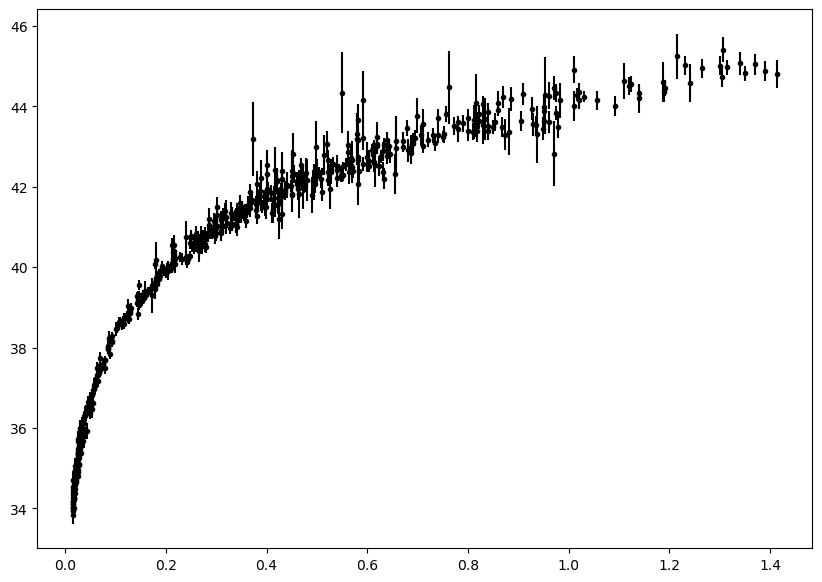

In [21]:
z_vec_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 0)
mu_data_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 1)
mu_err_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 2)


plt.figure(figsize = (15,3))
z_datos_ordenado, mu_datos_ordenado, mu_error_datos_ordenado = zip(*sorted(zip(z_vec_union, mu_data_union, mu_err_union)))
#print(z_datos_ordenado)
plt.figure(figsize=(10,7))
plt.errorbar(z_datos_ordenado, mu_datos_ordenado, yerr=mu_error_datos_ordenado, fmt = ".k")
plt.show()

# Importamos los datos de JLA

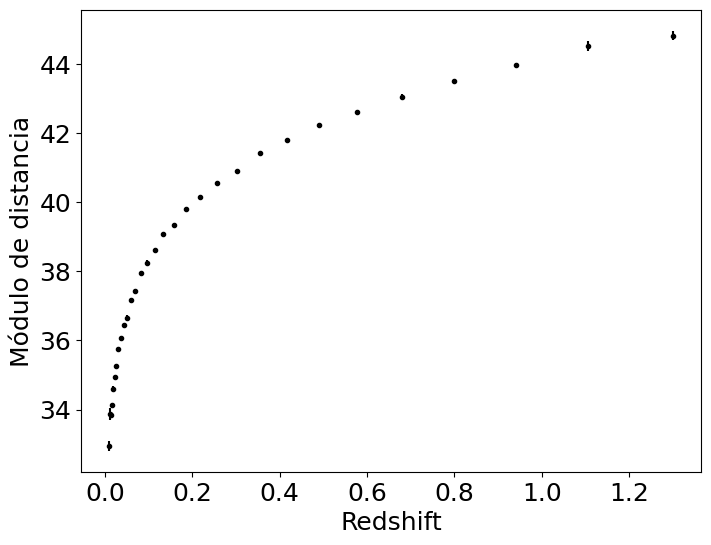

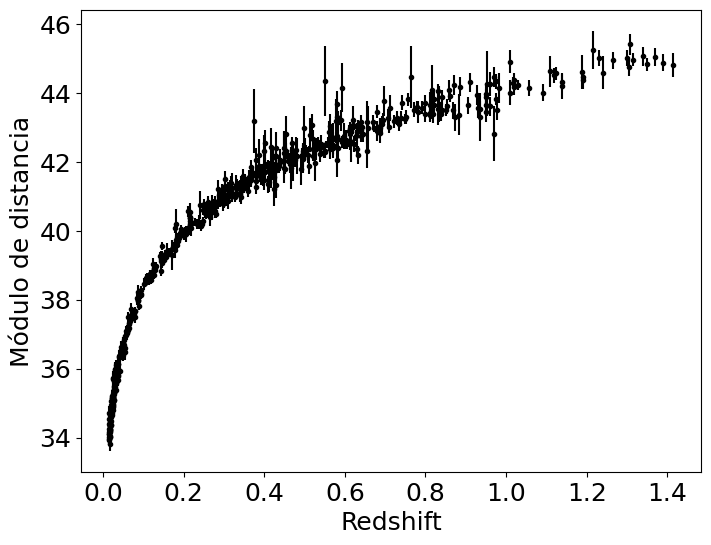

In [35]:
z_vec_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 0)
mu_data_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 1)
mu_err_union = np.genfromtxt("datos_union.csv", delimiter = ";", usecols = 2)

JLA_z_mu= np.genfromtxt("jla_mub_0.csv", delimiter = ',')
cov_matrix = np.genfromtxt("jla_mub_covmatrix.csv", delimiter = ',').reshape(31,31)

z_vec_jla = JLA_z_mu[:, 0] 
mu_data_jla = JLA_z_mu[:, 1]
mu_err_jla = np.sqrt(np.diagonal(cov_matrix))

plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(8,6))
#plt.errorbar(z_vec_union, mu_data_union, mu_err_union, fmt = ".k")
plt.errorbar(z_vec_jla, mu_data_jla, mu_err_jla, fmt = ".k")
plt.xlabel("Redshift")
plt.ylabel("Módulo de distancia")
plt.savefig("catalogo_jla.pdf")
plt.show()

plt.figure(figsize=(8,6))
plt.errorbar(z_vec_union, mu_data_union, mu_err_union, fmt = ".k")
#plt.errorbar(z_vec_jla, mu_data_jla, mu_err_jla, fmt = ".k")
plt.xlabel("Redshift")
plt.ylabel("Módulo de distancia")
plt.savefig("catalogo_union.pdf")
plt.show()


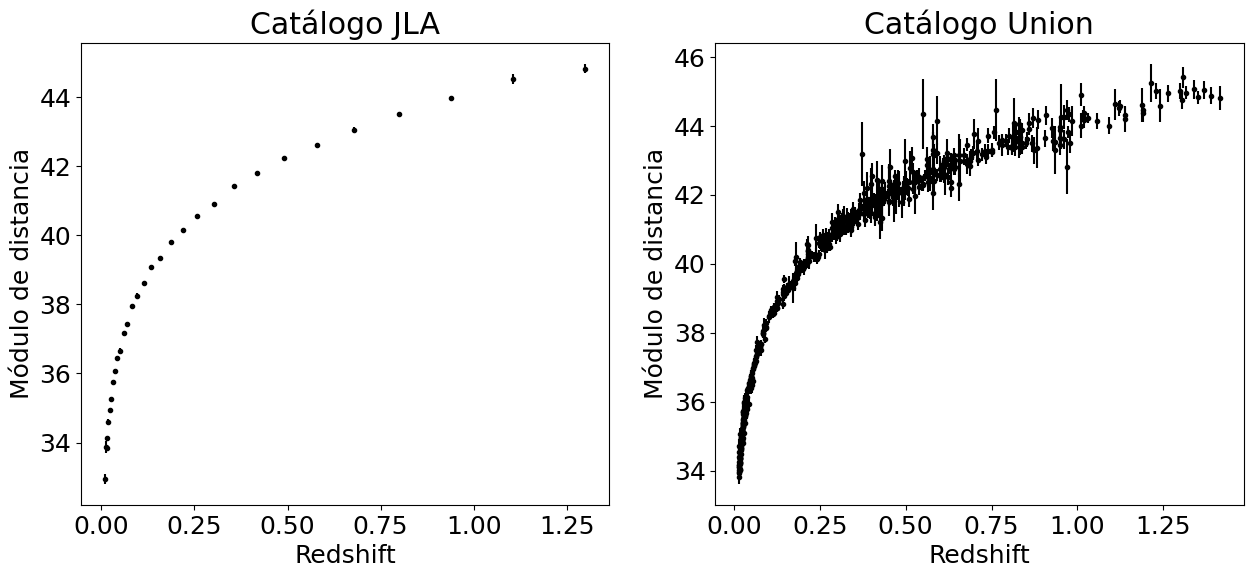

In [42]:
import numpy as np
import matplotlib.pyplot as plt

z_vec_union = np.genfromtxt("datos_union.csv", delimiter=";", usecols=0)
mu_data_union = np.genfromtxt("datos_union.csv", delimiter=";", usecols=1)
mu_err_union = np.genfromtxt("datos_union.csv", delimiter=";", usecols=2)

JLA_z_mu = np.genfromtxt("jla_mub_0.csv", delimiter=',')
cov_matrix = np.genfromtxt("jla_mub_covmatrix.csv", delimiter=',').reshape(31, 31)

z_vec_jla = JLA_z_mu[:, 0]
mu_data_jla = JLA_z_mu[:, 1]
mu_err_jla = np.sqrt(np.diagonal(cov_matrix))

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].errorbar(z_vec_jla, mu_data_jla, mu_err_jla, fmt=".k")
axs[0].set(xlabel="Redshift", ylabel="Módulo de distancia")
axs[0].set_title('Catálogo JLA')

axs[1].errorbar(z_vec_union, mu_data_union, mu_err_union, fmt=".k")
axs[1].set(xlabel="Redshift", ylabel="Módulo de distancia")
axs[1].set_title('Catálogo Union')

plt.subplots_adjust(wspace=0.2)

# Aumentar la resolución de la imagen (dpi)
dpi = 300  # Ajusta este valor según tus necesidades

plt.savefig("figura_combinada.png", dpi=dpi)
plt.show()


Definimos el posterior, en este caso con una función likelihood para cada uno de los catálogos. La función likelohood total será la suma de ambas.

In [6]:
def log_likelihood_UNION(theta, z_vec, distancia, yerr):
    h0, Omega_m0 = theta # Parámetros a minimizar
    Omega_l0 = 1 - Omega_m0
    Omega_r0 = 0
    model = mod_dist_vec(z_vec, h0, Omega_m0)
    sigma2 = np.array(yerr)**2
    return -0.5 * np.sum((distancia - model) ** 2 / sigma2)

cov_inv = np.linalg.inv(cov_matrix) # Calculating the inverse matrix
cov_eigvals = np.linalg.eig(cov_matrix)[1] # Calculates the eigenvalues of the covariance matrix

def log_probability_JLA(theta, z_vec, mu_data, cov_matrix, cov_inv, cov_eigvals):
    """Compute the Gaussian log-likelihood for a given distance modulus data, distance modulus theorical and covariance."""
    h0, Omega_m0= theta 
    Omega_r0 = 0.0
    cov_len = len(cov_matrix)
    mu_model_array = mod_dist_vec(z_vec, h0, Omega_m0)
    return -0.5 * (np.matmul((mu_model_array - mu_data) , np.matmul(cov_inv , (mu_model_array - mu_data)))) - .5 * (np.sum(np.log(np.absolute(cov_eigvals[1]))) + cov_len * np.log(2*np.pi))

def log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals):
    return log_likelihood_UNION(theta, z_vec_union, mu_data_union, mu_err_union) + log_probability_JLA(theta, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)
    #return log_probability_JLA(theta, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)
def log_prior(theta):
    h0, Omega_m0 = theta # Parámetros a minimizar
    if 50< h0 < 100 and 0 < Omega_m0 < 1: # and and 0.0 < Omega_m0+Omega_l0+Omega_k(Omega_m0, Omega_l0, Omega_r0) <= 1.0
        return 0.0
    return -np.inf

def condition(theta, z):
    H, Omega_m0 = theta
    Omega_l0 = 1 - Omega_m0
    z_max = np.max(z)
    result = Omega_m0*(1+z_max)**3  + Omega_k(Omega_m0, Omega_l0, Omega_r0)*(1+z_max)**2 + Omega_l0
    if result < 0:
        return -np.inf
    return result


def log_probability(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals):
    if not np.isfinite(log_prior(theta)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, z_vec_union)):
        lp = -np.inf
        return lp
    if not np.isfinite(condition(theta, z_vec_jla)):
        lp = -np.inf
        return lp
    lp = 0.0
    Likelihood = log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals) +lp
    return Likelihood # Si el valor de lp es finito, contruimos la funcion probabilidad

Comprobamos que la función likelihood da como salida un número

In [7]:
theta = [67, 0.33]

log_likelihood(theta, z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals)


-326.43068826926725

Iniciamos el MCMC

In [8]:
max_n = 10000

# We'll track how the average autocorrelation time estimate changes
index = 0
autocorr = np.empty(max_n)

# This will be useful to testing convergence
old_tau = np.inf

h0_random = np.random.uniform(50, 100, 100)
omega_m_random = np.random.uniform(0, 1, 100)
pos = []
pos = np.column_stack((h0_random, omega_m_random)) # Escribe los 2 vectores como columnas
nwalkers, ndim = pos.shape  # nwalker y ndim toma el valor del número de filas y el número de columnas del vector "pos", respectivamente.



with Pool(processes=6) as pool:
    sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(z_vec_union, mu_data_union, mu_err_union, z_vec_jla, mu_data_jla, cov_matrix, cov_inv, cov_eigvals))
    # Now we'll sample for up to max_n steps
    for sample in sampler.sample(pos, iterations=max_n, progress=True):
        # Only check convergence every 100 steps
        if sampler.iteration % 100:
            continue

        # Compute the autocorrelation time so far
        # Using tol=0 means that we'll always get an estimate even
        # if it isn't trustworthy
        tau = sampler.get_autocorr_time(tol=0)
        autocorr[index] = np.mean(tau)
        index += 1

        # Check convergence
        converged = np.all(tau * 100 < sampler.iteration)
        converged &= np.all(np.abs(old_tau - tau) / tau < 0.01)
        if converged:
            break
        old_tau = tau
        n = 100 * np.arange(1, index + 1)
        y = autocorr[:index]
        plt.plot(n, n / 100.0, "--k")
        plt.plot(n, y)
        plt.xlim(0, n.max())
        plt.ylim(0, y.max() + 0.1 * (y.max() - y.min()))
        plt.xlabel("number of steps")
        plt.ylabel(r"mean $\hat{\tau}$")
        file_name_fig = 'autocorrelation.png'
        plt.savefig(file_name_fig)
        plt.close()

 27%|██▋       | 2700/10000 [4:06:52<11:07:27,  5.49s/it]


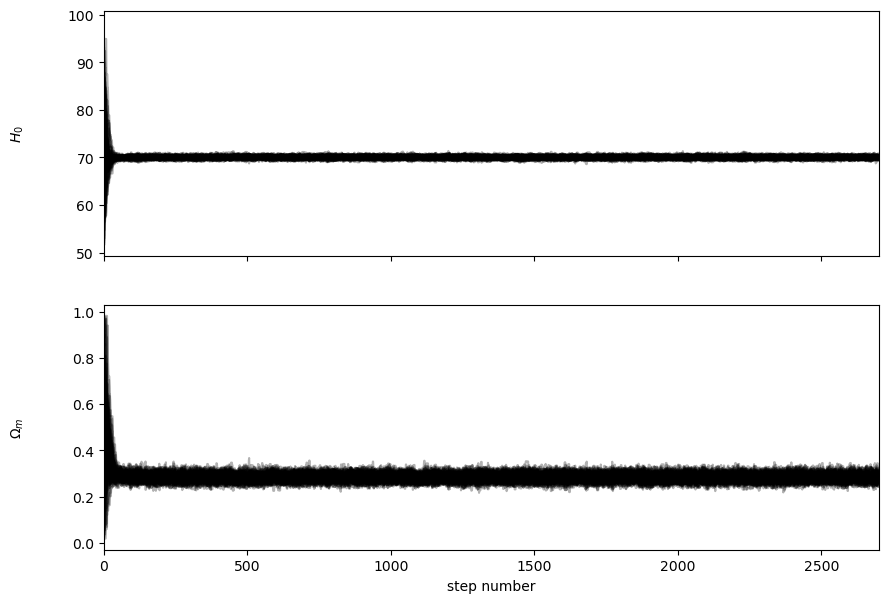

In [9]:
fig, axes = plt.subplots(2, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$H_0$", "$\Omega_m$"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [10]:
tau = sampler.get_autocorr_time()  # autocorrelation
print(tau)
print("-----")
burnin = int(2 * np.max(tau))  # burn in phase
thin = int(0.5 * np.min(tau))  #
flat_samples = sampler.get_chain(discard=burnin, thin=thin, flat=True)
print(flat_samples)
np.savetxt('flat_samples_union+jla_flat.csv', flat_samples, delimiter = ',')

[20.73593124 26.37912578]
-----
[[69.91512659  0.30272161]
 [69.64998347  0.30502773]
 [69.67412677  0.31514203]
 ...
 [70.64576674  0.24589458]
 [69.74325673  0.28724329]
 [69.69843885  0.31722668]]


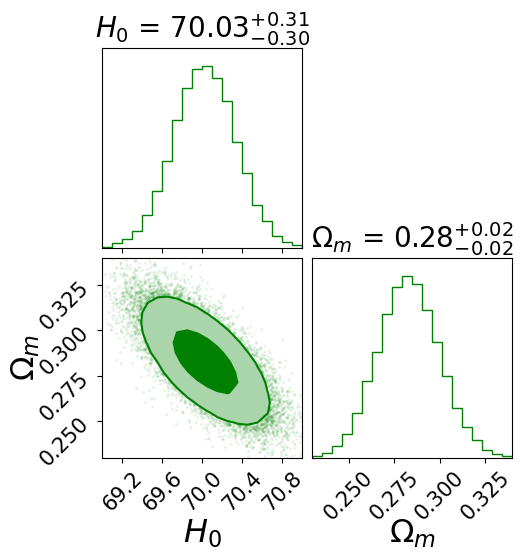

In [2]:
import corner
# Parámetros del modelo
labels = ["$H_0$", "$\Omega_m$"]
flat_samples = np.genfromtxt('flat_samples_union+jla_flat.csv', delimiter = ',')
fig = corner.corner(flat_samples, labels=labels,fill_contours=True,bins=20, color='green', show_titles=True,smooth=1.0, 
                        label_kwargs={"fontsize": 23},title_kwargs={"fontsize": 20}, tick_kwargs={"fontsize": 15},
                        levels=(1-np.exp(-0.5),1-np.exp(-2.0)), range = [(69, 71), (0.23, 0.34)])
fontsize = 15
for ax in fig.get_axes():
    plt.setp(ax.get_xticklabels(), fontsize=fontsize)
    plt.setp(ax.get_yticklabels(), fontsize=fontsize)

fig.savefig('corner_unio+jla_flat.pdf')

In [3]:
from IPython.display import display, Math

results = []
for i in range(2):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    print(mcmc)
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    append = [mcmc[1], q[0], q[1]]
    results.append(append)
    display(Math(txt))
np.savetxt('Resultados_union+jla_flat.csv', results, delimiter=',')
    

[69.72147701 70.02624777 70.33583164]


<IPython.core.display.Math object>

[0.26641099 0.28297675 0.29992113]


<IPython.core.display.Math object>